# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from tqdm import tqdm
from functions_for_project import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. One of them is a top-level list of attributes and descriptions, organized by informational category. The other is a detailed mapping of data values for each feature in alphabetical order.

Considering the size of the datasets, it may take some time for them to load completely. I did the project on my laptop which has only 8Gb of RAM and it took me a while to run some of the functions.

NOTE!Per terms and conditions all data is deleted after the project is done. 

In [3]:
# load the data 
azdias = pd.read_csv('azdias.csv')
customers = pd.read_csv('customers.csv')
values = pd.read_excel('DIAS_Attributes-Values_2017.xlsx', header=1)

In [3]:
# have a look at dataframes
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [5]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [7]:
values.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


So, in all 3 dataframes there is a column 'Unnamed: 0' which we can drop right away as it doesn't contain any usefull information. Also column 'LNR' in azdias and customers datasets can be dropped as it just people's IDs in the datasets. I also want to fill in missing values in 'Attribute' column of values dataframe.

In [8]:
azdias.drop(['Unnamed: 0','LNR'], axis=1, inplace=True)
customers.drop(['Unnamed: 0','LNR'], axis=1, inplace=True)
values.drop('Unnamed: 0', axis=1, inplace=True)
values['Attribute'].fillna(method='ffill', inplace=True)

Let's have a look at the size of the data we're working with.

In [9]:
print(f'Azdias dataframe has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print(f'Customers dataframe has {customers.shape[0]} rows and {customers.shape[1]} columns')

Azdias dataframe has 891221 rows and 365 columns
Customers dataframe has 191652 rows and 368 columns


Now I want to drop duplicates (if there are any) in dataframes.

In [10]:
azdias.drop_duplicates(inplace=True)
customers.drop_duplicates(inplace=True)

# see if size of the dataframes changes
print(f'Azdias dataframe has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print(f'Customers dataframe has {customers.shape[0]} rows and {customers.shape[1]} columns')

Azdias dataframe has 845459 rows and 365 columns
Customers dataframe has 150531 rows and 368 columns


It turns out there were some duplicated rows in the dataframes. Getting rid of them reduced the size of the data a bit.

Now, let's check out how many columns in the demographic data we have description of.

In [11]:
len(set(values['Attribute']))

314

So, we have descriptions of 314 columns in values dataset. I want to keep only those columns in azdias and customers dataframes that have information description.

In [12]:
columns = list(np.intersect1d(azdias.columns.to_list(),list(set(values['Attribute']))))
len(columns)

272

272 is the number of columns we'll be working with in both of the datasets in this part of the project.

In [13]:
azdias = azdias[columns]
customers = customers[columns]

In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,-1,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,-1,NaN,-1,NaN,NaN,NaN,3
1,-1,1,0.0,2,11.0,0.0,2.0,0.0,6.0,8,...,5,6,1,3,0.0,2,9.0,4.0,3.0,5
2,-1,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4,...,4,3,4,2,0.0,1,9.0,2.0,3.0,5
3,2,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2,...,5,4,4,1,0.0,1,9.0,7.0,NaN,3
4,-1,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6,...,6,2,7,2,0.0,2,9.0,3.0,2.0,4


In [15]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,2,4,10.0,1,1.0,0.0,2.0,0.0,3.0,1,...,6,1,6,3,0.0,1,9.0,7.0,6.0,3
1,-1,4,11.0,1,NaN,NaN,3.0,0.0,NaN,NaN,...,3,1,7,3,0.0,1,9.0,NaN,0.0,3
2,-1,4,6.0,2,1.0,0.0,1.0,0.0,7.0,5,...,2,1,3,1,0.0,2,9.0,2.0,6.0,3
3,1,4,8.0,1,0.0,NaN,0.0,0.0,7.0,4,...,6,4,7,0,0.0,1,9.0,7.0,NaN,1
4,-1,3,20.0,1,7.0,0.0,4.0,0.0,3.0,7,...,4,4,5,1,0.0,2,9.0,3.0,2.0,1


Now, we need to deal with NaN values. After looking at features description, we can see that some of the missing values in the dataframes are encoded as -1, 0 or 9. I want to create a dataframe that holds every column and how missing values are enocoded in that column.

In [16]:
# create a dataframe where one column is the the name of the column in azdias or customers dataframe
# and another column shows how NaN values are encoded in that column
values_nan = values[values['Meaning'].str.contains('unknown', case=False, na=False)]
values_nan['Value'] = values_nan['Value'].apply(str)
values_nan = values_nan.groupby('Attribute')['Value'].apply(','.join).reset_index()
values_nan.head()

,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1


In [17]:
len(values_nan)

233

In [18]:
feature_info('CAMEO_DEU_2015',values)

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,NaN,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,NaN,1C,Successful Songwriter
64,CAMEO_DEU_2015,NaN,1D,Old Nobility
65,CAMEO_DEU_2015,NaN,1E,City Nobility
66,CAMEO_DEU_2015,NaN,2A,Cottage Chic
67,CAMEO_DEU_2015,NaN,2B,Noble Jogger
68,CAMEO_DEU_2015,NaN,2C,Established gourmet
69,CAMEO_DEU_2015,NaN,2D,Fine Management
70,CAMEO_DEU_2015,NaN,3A,Career & Family


In [19]:
feature_info('CAMEO_DEUG_2015',values)

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


233 out of 272 columns have some of their missing values coded as -1, 0 or 9. I'd like to turn them into NaN and see how much of the data is actually missing in the dataframes. Also, some of the columns have their missing values coded differently. For example, 'X' or 'XX' in CAMEO_DEUG_2015 and CAMEO_DEU_2015 columns respectively. As a metter of fact, since both of the columns contain almost identica information, I'll keep only one of them (CAMEO_DEUG_2015).

In [20]:
azdias.drop('CAMEO_DEU_2015', axis=1, inplace=True)

## Part 1: Unsupervised learning.

In this part we'll be clustering the data trying to find out what describes our customer the best and which groups of people have most of potential customers.

In [21]:
# decode missing values in azdias dataset
azdias = decode_nan(azdias,values_nan)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,NaN,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,NaN,NaN,NaN,NaN,NaN,NaN,3
1,NaN,1,NaN,2,11.0,0.0,2.0,0.0,6.0,8.0,...,5,6,1,3.0,NaN,2.0,9.0,4.0,3.0,5
2,NaN,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4.0,...,4,3,4,2.0,NaN,1.0,9.0,2.0,3.0,5
3,2.0,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2.0,...,5,4,4,1.0,NaN,1.0,9.0,7.0,NaN,3
4,NaN,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6.0,...,6,2,7,2.0,NaN,2.0,9.0,3.0,2.0,4


In [22]:
# do the same with customers dataframe
customers = decode_nan(customers,values_nan)
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,2.0,4,10.0,1,1.0,0.0,2.0,0.0,3.0,1.0,...,6,1,6,3.0,NaN,1.0,9.0,7.0,6.0,3
1,NaN,4,11.0,1,NaN,NaN,3.0,0.0,NaN,NaN,...,3,1,7,3.0,NaN,1.0,9.0,NaN,NaN,3
2,NaN,4,6.0,2,1.0,0.0,1.0,0.0,7.0,5.0,...,2,1,3,1.0,NaN,2.0,9.0,2.0,6.0,3
3,1.0,4,8.0,1,0.0,NaN,0.0,0.0,7.0,4.0,...,6,4,7,0.0,NaN,1.0,9.0,7.0,NaN,1
4,NaN,3,20.0,1,7.0,0.0,4.0,0.0,3.0,7.0,...,4,4,5,1.0,NaN,2.0,9.0,3.0,2.0,1


Now that we decoded missing values in the dataframes, let's check how much data is actually missing in each column. Since we'll be building clustering model on general data, I'll only check missing data in azdias dataset and drop columns that have lots of data missing. I'll then use columns from azdias dataset on customers dataset.

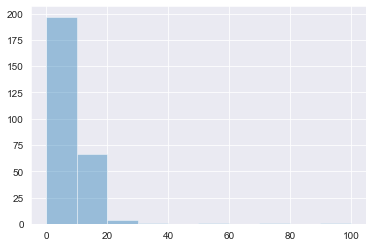

In [23]:
# number of data missing into separate dataframe
azdias_null = azdias.isnull().sum()/len(azdias)*100
# check missing values' distribution
sns.distplot(azdias_null, bins=10, kde=False);

So, majority of columns have less than 20% of data missing. I'll use 20% as threshold and drop all columns that have more than 20% of data missing.

In [24]:
# columns to work with
final_cols = azdias_null[azdias_null<20].index.to_list()

# save list of columns for later use
#with open('final_columns.pickle','wb') as f:
    #pickle.dump(final_cols,f)
    
# have a look at columns
print(final_cols)
print(' ')
print(f'{len(final_cols)} columns left to work with')

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KB

In [25]:
azdias = azdias[final_cols]
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,...,7,2,3,1,NaN,NaN,NaN,NaN,NaN,3
1,1,2,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,...,4,5,6,1,3.0,2.0,9.0,4.0,3.0,5
2,3,2,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,...,3,4,3,4,2.0,1.0,9.0,2.0,3.0,5
3,4,2,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,...,2,5,4,4,1.0,1.0,9.0,7.0,NaN,3
4,3,1,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,...,4,6,2,7,2.0,2.0,9.0,3.0,2.0,4


Before trying to clusterize the data, I'd like to see what groups of people are more represented in the customers dataset compared to general population. I'll plot some countplots for 'HH_EINKOMMEN_SCORE', 'CAMEO_DEUG_2015' and 'PRAEGENDE_JUGENDJAHRE' columns.

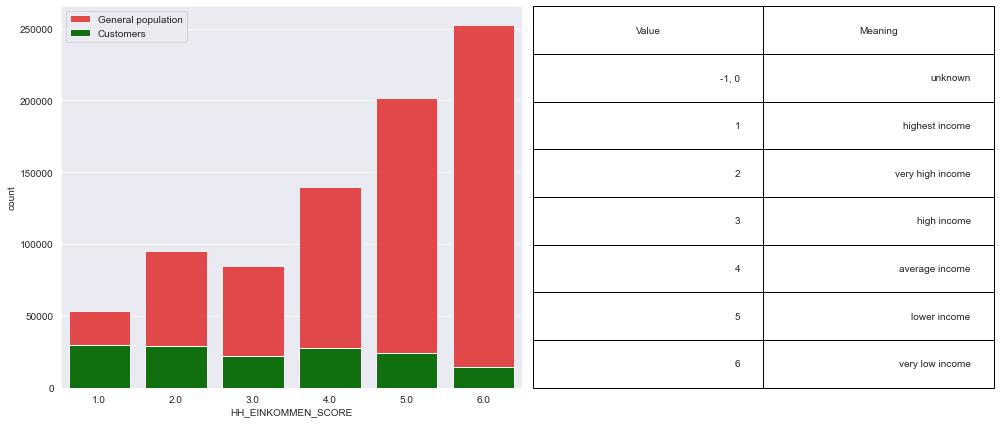

In [26]:
countplot('HH_EINKOMMEN_SCORE',azdias,customers,values);

According to the plot we can see that household with very low income are most represented in general population data while those households are actually the least represented in customers dataset. Households with highest or very high income are most represented in customers data.

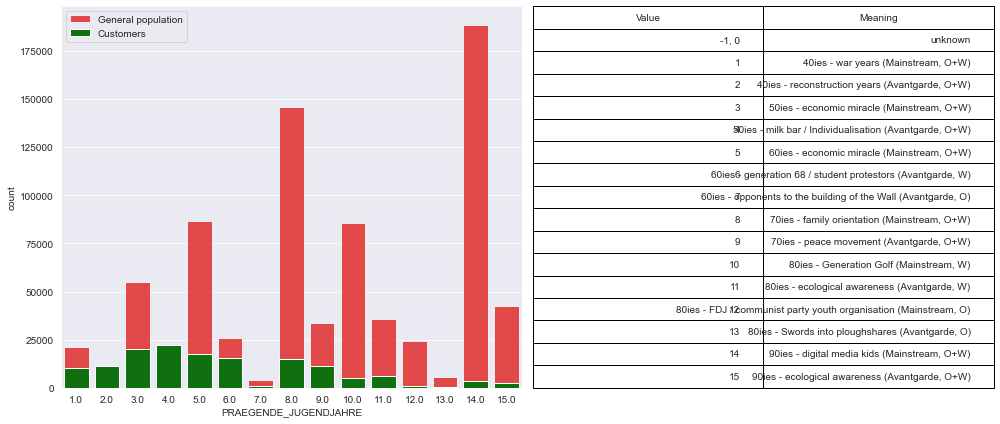

In [27]:
countplot('PRAEGENDE_JUGENDJAHRE',azdias,customers,values);

PRAEGENDE_JUGENDJAHRE column is actually very interesting and shows the dominant movement (mainstream or avantgarde) in the person's youth. We can create two new columns out of this one: one column showing the person's youth decade and another one showing the movement this person supported during his/her youth.

In [28]:
# create two new columns and drop the original one
for df in [azdias,customers]:
    df['YOUTH_DECADE'] = youth_decade(df)
    df['MOVEMENT'] = movement(df)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

Now let's plot new columns.

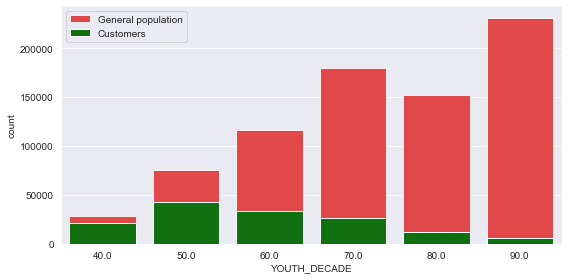

In [31]:
countplot('YOUTH_DECADE',azdias,customers,values,figsize=(8,4),show_info=False);

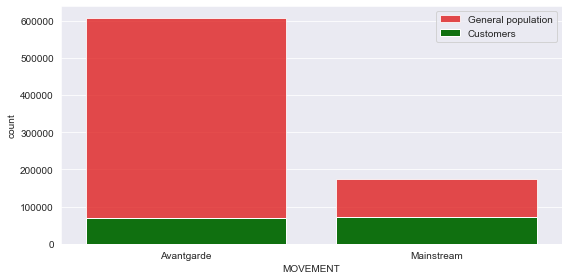

In [32]:
countplot('MOVEMENT',azdias,customers,values,figsize=(8,4),show_info=False);

In the graphs above we can see that people who experienced their youth in 40th through 70th are most represented in customers data while those who had their youth in 80th or 90th are least represented amoung the customers. As for the movement, while avantgarde was a dominant movement in most of the people's youth in general data, customers are almost equally split between mainstream and avantgarde.

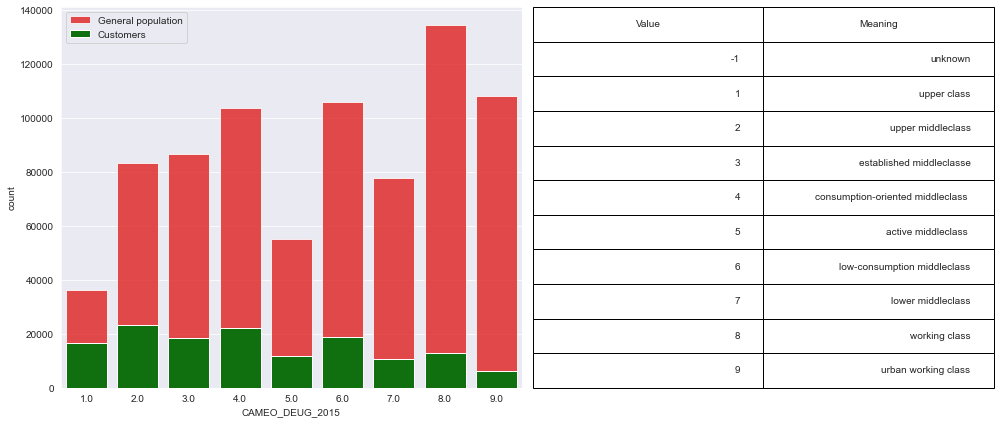

In [33]:
countplot('CAMEO_DEUG_2015',azdias,customers,values);

According to the graph above we can see that while people of working and urban working classes are more represented in general demographic dataset (azdias), the customers are actually more represented in upper and consumption-oriented middleclasses.

We can already see the shape of our potential customer. It's a person of old generation with more than average or high income and both avantgarde and mainstream views.
Let's go into unsupervised learning part, cluster the data and try to find patterns amoung our customers.

I'm going to use KMeans for clustering but before doing so I need to fill in missing values and label object type data. As there are many features I'll also use PCA to wrap them into smaller number of components. We have both numeric and categorical features in the dataset and numeric ones are actually marked in values dataset. I want to use a round mean value of numeric features and a modal value for categorical features to fill in missing values. I'll use LabelEncoder to label object type data and StandardScaler to scale the data before applying PCA. After PCA is applied I'll use Elbow method to determine number of clusters for KMeans.

In [34]:
# fill in missing values
azdias = fill_nan(azdias,values)

# label object type data
azdias = label_obj(azdias)

# scale the data
azdias = scale_data(azdias)

# check dataset
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP,YOUTH_DECADE,MOVEMENT
0,-0.735670,-1.043464,-0.017729,-0.121495,0.231491,-0.059436,0.805212,0.928744,-0.983414,-0.234687,...,-0.399531,-1.587806,-0.544490,0.906335,0.5551,-0.520438,0.915778,-0.275619,1.050041,0.511305
1,-1.661357,0.958347,0.179997,-0.121495,0.231491,-0.059436,0.805212,0.928744,0.973763,-0.234687,...,1.318625,-1.587806,1.455722,0.906335,0.5551,0.003255,-0.770939,1.167249,1.050041,0.511305
2,0.190018,0.958347,0.114088,-0.121495,-0.647433,-0.059436,-1.043688,-0.682094,-0.331022,-0.234687,...,-0.399531,-0.093280,0.455616,-1.103345,0.5551,-1.044131,-0.770939,1.167249,1.050041,-1.955779
3,1.115705,0.958347,-0.479090,-0.121495,-1.526356,-0.059436,-0.119238,-1.487513,-0.983414,-0.234687,...,0.173188,-0.093280,-0.544490,-1.103345,0.5551,1.574335,0.915778,-0.275619,-0.310040,0.511305
4,0.190018,-1.043464,-0.347272,-0.121495,1.989338,-0.059436,-1.043688,0.123325,0.973763,5.224956,...,-0.972250,1.401246,0.455616,0.906335,0.5551,-0.520438,-1.333178,0.445815,-0.310040,0.511305


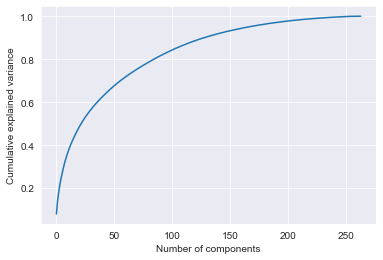

In [35]:
# now, find optimal number of principal components
pca = PCA().fit(azdias)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

I'll be using 90 principal components which explain about 80% of data variance.

In [36]:
# apply pca
azdias_pca = apply_pca(azdias,90)
azdias_pca.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,...,pc_81,pc_82,pc_83,pc_84,pc_85,pc_86,pc_87,pc_88,pc_89,pc_90
0,-2.272147,0.510525,-1.109202,-2.874523,-1.552249,-1.663667,-0.707478,0.634464,-0.299251,0.776393,...,-0.075614,-0.870058,-0.298358,-0.391400,-0.064047,0.086705,0.038494,-0.497392,0.204350,-0.335599
1,-1.161171,5.749881,2.203486,-4.473629,-1.282940,1.761081,-4.910621,1.268567,0.339954,-0.550674,...,2.264492,-0.470416,1.115929,0.006782,1.482731,-1.396633,-2.346281,0.544055,0.016486,0.715881
2,1.418473,2.742748,-2.596360,0.163953,-3.795811,-6.281767,1.190108,0.928435,-0.638180,0.292198,...,-1.310691,-1.247098,-1.206354,-0.554897,-0.679567,0.514817,0.822922,0.509906,0.629296,0.701495
3,4.366159,0.303089,-5.211958,-1.965733,-0.418521,0.301457,-1.403689,-1.707499,1.750784,-2.893402,...,-0.032785,0.273513,0.507176,-0.403217,1.068398,-0.788436,1.007831,0.905946,0.252184,0.099582
4,4.646843,-0.041728,9.313907,5.466562,3.540997,-0.446953,3.160808,-3.644206,0.057123,-4.924410,...,-0.604447,-0.784144,0.818166,0.971216,-0.009147,0.406770,-0.484072,1.272672,-0.338517,0.342872


The data is ready for the Elbow method to find an optimal number of clusters.

In [207]:
scores = find_k(azdias_pca)

100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:36:20<00:00, 240.86s/it]


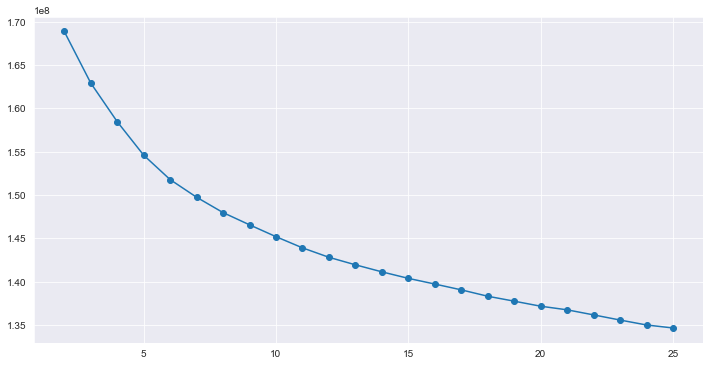

In [208]:
plt.figure(figsize=(12,6))
plt.plot(scores['Number of clusters'], scores['Sum of squared distances'], marker='o');

So, we got a gradual decrease in sum of distances instead of sharp elbow. I'll choose 10 as number of clusters but this is somehow arbitrary.

In [37]:
# init KMeans with 10 cluster
kmeans = KMeans(n_clusters=10, random_state=42)

Now I'd like to create a pipeline that will process our data before we apply KMeans clustering to it. I'll load the original datasets again and use data processing pipeline on them. And the steps taken to process the data are:
- pick out columns to work with
- decode missing values back to NaNs
- engineer new columns and drop some of the useless ones
- fill in NaNs: mean values for numerical columns (which columns are numerical is described in values dataset) and modal values for categorical columns)
- label object type data
- scale the data
- apply PCA using 90 principal components

In [38]:
# load original datasets
azdias = pd.read_csv('azdias.csv')
customers = pd.read_csv('customers.csv')

# a pipeline to process the data before clustering
pipeline_for_clustering = Pipeline(steps=[
    ('processing',ProcessForClustering(values_nan,values)),
    ('stardardize',StandardScaler()),
    ('pca',PCA(n_components=90, random_state=42))
])

# process data before clustering
azdias_pca = pipeline_for_clustering.fit_transform(azdias)
customers_pca = pipeline_for_clustering.transform(customers)

I'll keep clusters in seperate columns called 'CLUSTERS' in already preprocessed datasets (no filling in NaNs, labeling object type data and scaling). Then I'll try to figure out which clusters of people need to be targeted as potential customers.

In [39]:
azdias_proc = ProcessForClustering(values_nan,values,fill_na=False,label_obj=False).fit_transform(azdias)
customers_proc = ProcessForClustering(values_nan,values,fill_na=False,label_obj=False).fit_transform(customers)

In [40]:
# train the model
kmeans.fit(azdias_pca)

# clusterize the data
azdias_proc['CLUSTERS'] = kmeans.predict(azdias_pca)
customers_proc['CLUSTERS'] = kmeans.predict(customers_pca)

Now that we have the clusters determined let's see if can definitely say which one holds the most of potential customers.

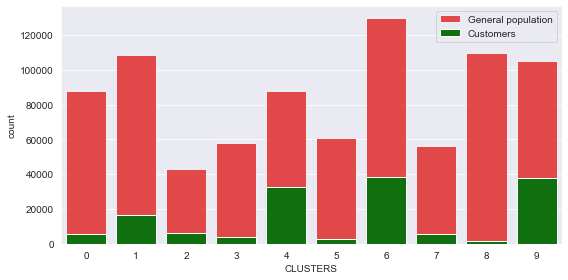

In [41]:
countplot('CLUSTERS',azdias_proc,customers_proc,values,figsize=(8,4),
          show_info=False);

In the graph we can see that our known customers are cleraly mostly gathered in clusters 6, 9 and 4  and those clusters make more than 70% of all our known customers. Let's see if we can spot any particular features that make the customers in those customers stand out from general population. 
First, I want to compare modal values of categorical variables in every column. If a modal value in a particular column is different from modal value of that column in on of the biggest customer clusters, we'll look closely on that column.

In [42]:
# numerical variables
numeric = [col for col in values[values['Meaning'].str.contains('numeric', case=False, na=False)]['Attribute'] \
           if col in customers_proc.columns]


# categorical variables
categorical = [col for col in customers_proc.columns if col not in numeric]

In [43]:
# a dataframe of all modal values in columns
modal_values = pd.DataFrame({'Columns':customers_proc[categorical].columns,
    'General_modal':[azdias_proc[col].mode()[0] for col in azdias_proc[categorical].columns],
    'Cluster_6_modal':[customers_proc[customers_proc['CLUSTERS']==6][col].mode()[0] for col in customers_proc[categorical].columns],
    'Cluster_9_modal':[customers_proc[customers_proc['CLUSTERS']==9][col].mode()[0] for col in customers_proc[categorical].columns],
    'Cluster_4_modal':[customers_proc[customers_proc['CLUSTERS']==4][col].mode()[0] for col in customers_proc[categorical].columns]})
modal_values.head()

,Columns,General_modal,Cluster_6_modal,Cluster_9_modal,Cluster_4_modal
0,ALTERSKATEGORIE_GROB,3,4,4,4
1,ANREDE_KZ,2,1,1,1
2,BALLRAUM,6,6,6,1
3,CAMEO_DEUG_2015,8,4,2,1
4,CJT_GESAMTTYP,4,2,3,2


In [44]:
# a loop to find columns with different to general population modal values
columns_to_explore = []

for i in range(len(modal_values)):
    
    general = modal_values['General_modal'][i]
    cluster_6 = modal_values['Cluster_6_modal'][i]
    cluster_9 = modal_values['Cluster_9_modal'][i]
    cluster_4 = modal_values['Cluster_4_modal'][i]
    
    if (general!=cluster_6 or general!=cluster_9 or general!=cluster_4):
        
        columns_to_explore.append(modal_values['Columns'][i])
        
print(columns_to_explore)
print(' ')
print(len(columns_to_explore))

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'EWDICHTE', 'FINANZTYP', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_UNAUFFAELLIGER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER4', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_AUTOQUOT', 'KBA05_CCM1', 'KBA05_CCM4', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST3', 'KBA05_HERSTTEMP', 'KBA05_KRSHERST1', 'KBA05_KW1', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_SEG5', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB2', 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA1

So, we have 139 columns to explore. I've looked through all of them and picked out the ones I found the most interesting. 

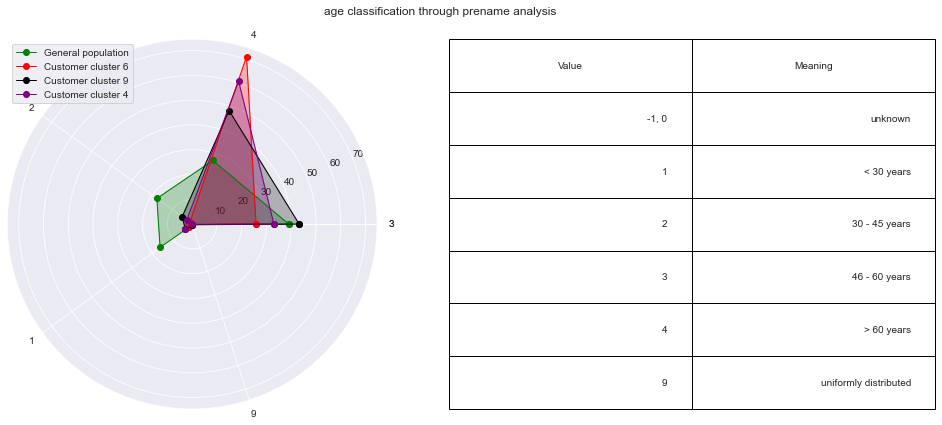

In [45]:
compare(azdias_proc,customers_proc,'ALTERSKATEGORIE_GROB',values);

The graph supports our previous assumption that our customer is of older generation. In general population about 40% of people are aged 45-60 years while in the biggest customer clusters more than 50% are aged >60 years. In customer cluster 6, for example, there are more than 70% of people over 60 years old.

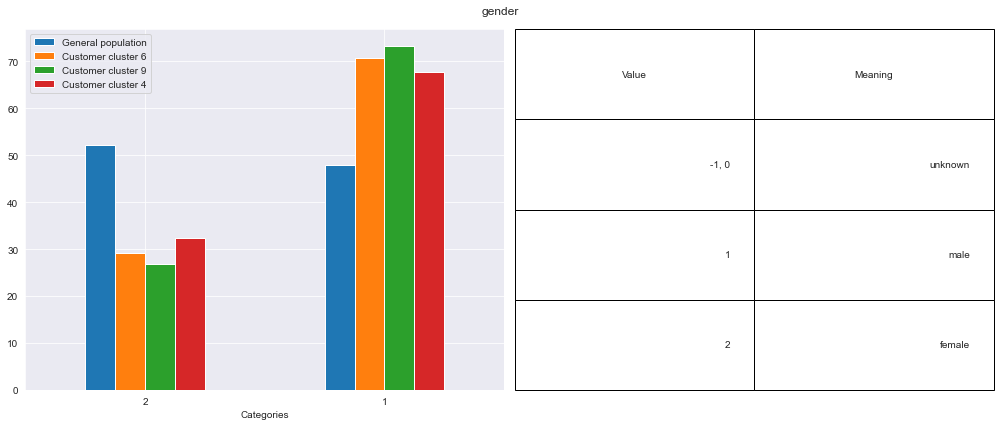

In [46]:
compare(azdias_proc,customers_proc,'ANREDE_KZ',values,polar=False);

This one is interesting. It shows that our customers are mostly males. General population is almost equally split between males and females (there are a bit more females) but customer clusters are mostly males.

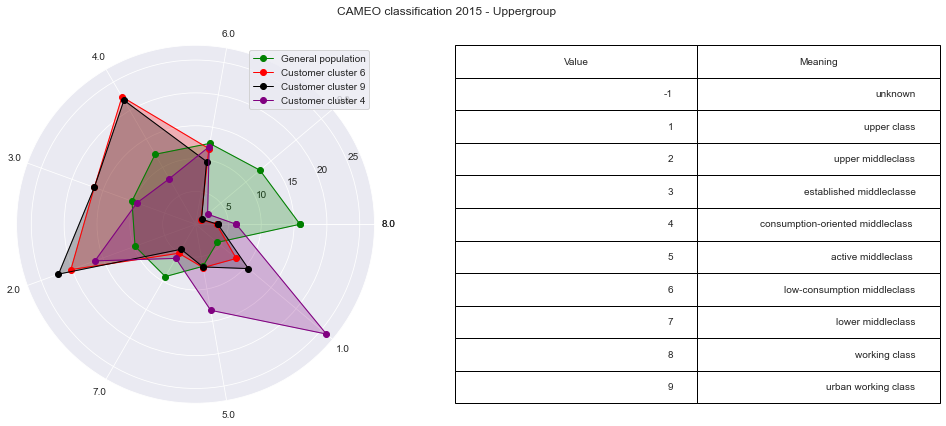

In [47]:
compare(azdias_proc,customers_proc,'CAMEO_DEUG_2015',values);

This graph also supports previous assumtion that majority of customers are well-of with about 20-25% of people belonging to consumption-oriented midleclass, upper middleclass and upper class in customer clusters 6, 9 and 4 respectively.

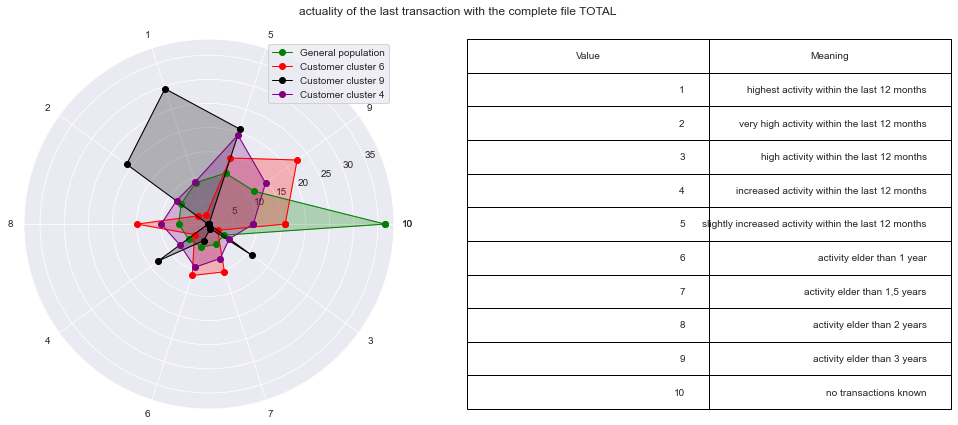

In [48]:
compare(azdias_proc,customers_proc,'D19_GESAMT_DATUM',values);

In general population almost 40% of people have no known transactions with the complete file TOTAL, while the biggest customer clusters show some high activity with almost third of customer cluster 9 showing highest activity within the last 12 months.

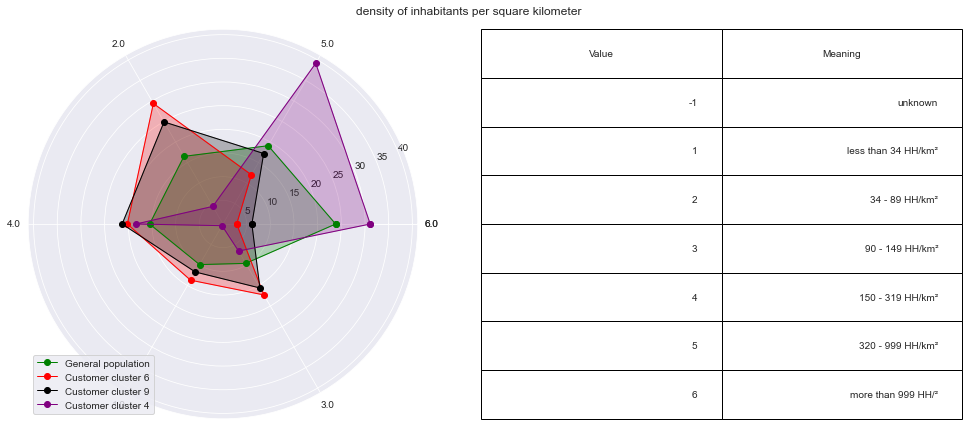

In [49]:
compare(azdias_proc,customers_proc,'EWDICHTE',values);

This graph shows that majority of people in customer clusters live in less densed areas (with 320-999 and less HH/square km).

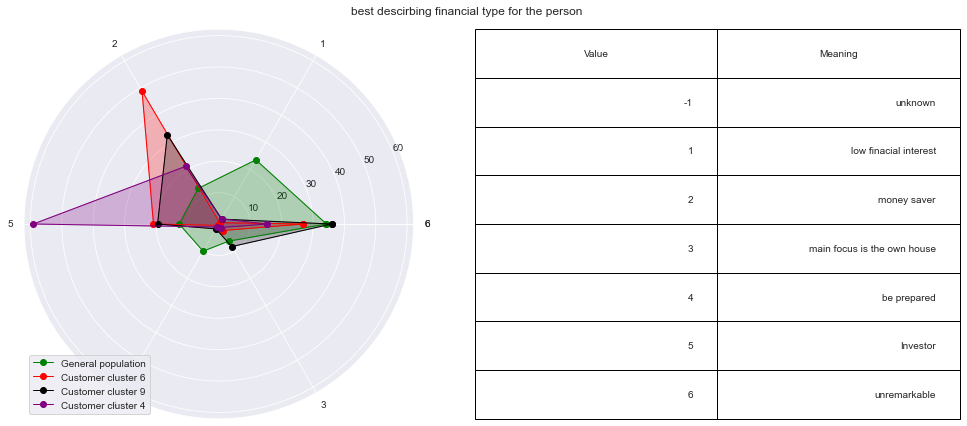

In [50]:
compare(azdias_proc,customers_proc,'FINANZTYP',values);

This one shows that majority of customer clusters describe themselves as investors (60% of cluster 4) or money saver (50% in cluster 6 and about 35% in cluster 9).

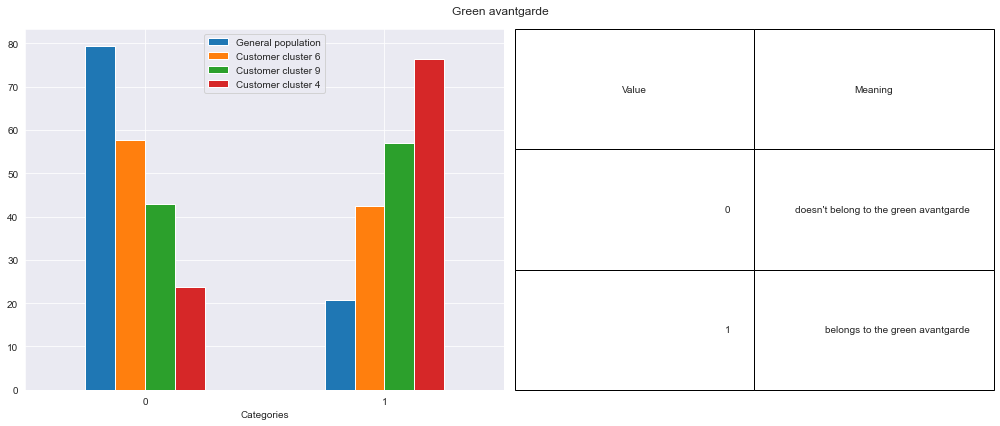

In [51]:
compare(azdias_proc,customers_proc,'GREEN_AVANTGARDE',values,polar=False);

Almost 80% of customer cluster 4 see themselves belonging to the green avantgarde while that number is only about 20% in general population.

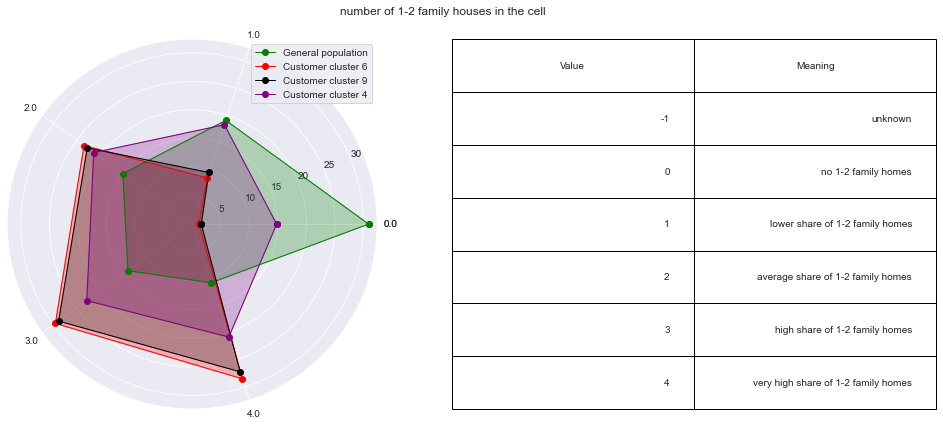

In [52]:
compare(azdias_proc,customers_proc,'KBA05_ANTG1',values);

General population tends to live in districts with low to none 1-2 family homes while majority of customer clusters are in districts with high or very high 1-2 family homes. 

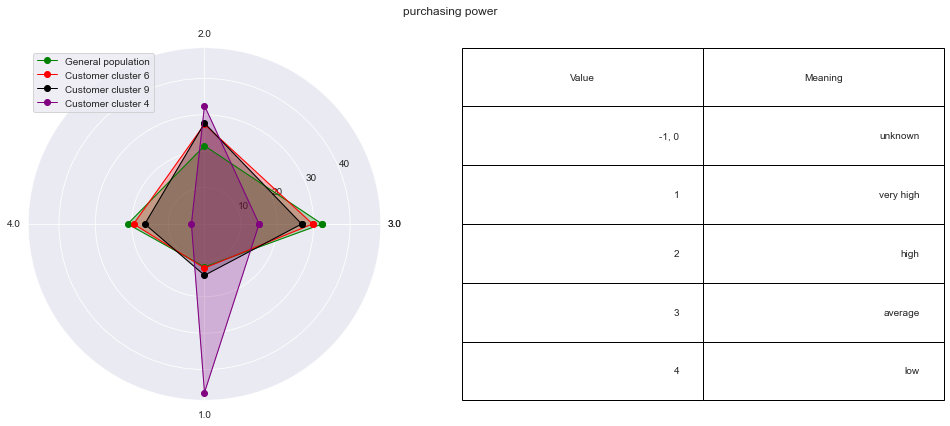

In [53]:
compare(azdias_proc,customers_proc,'KKK',values);

While general population shows average or low purchasing power, people in customer clusters tend to have a high or very high purchasing power.

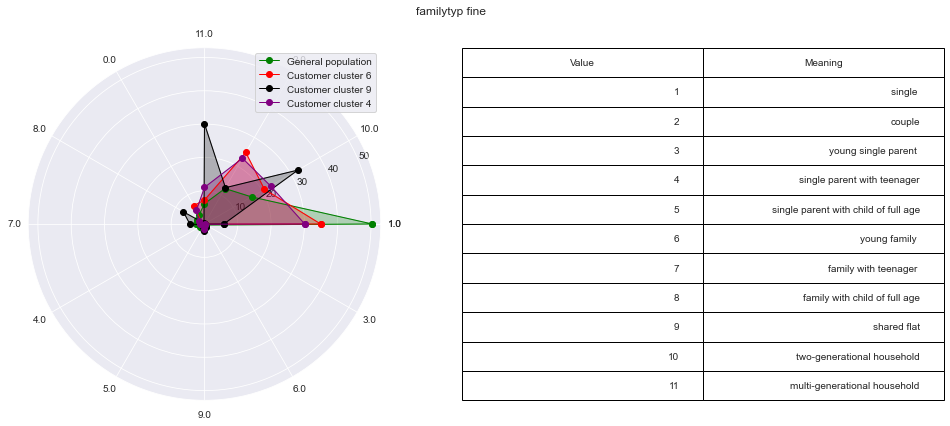

In [54]:
compare(azdias_proc,customers_proc,'LP_FAMILIE_FEIN',values);

Two thirds of people in customer cluster 9 live in two-generational or even multi-generational households while more than 50% of general population represent singles.

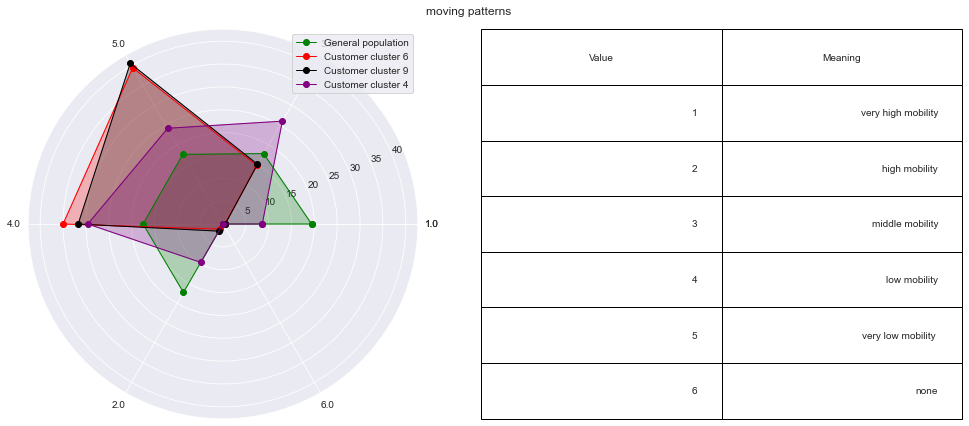

In [56]:
compare(azdias_proc,customers_proc,'MOBI_REGIO',values);

While almost half of general population have a very high or high mobility patterns, majority of customer clusters are aren't very mobile.

Well, here is a portrait of company's potential customer: it's most likely male of older generation (more than 60 years old), living in sparsely populated well-off (middleclass or higher) area in a two-generational or multi generational home. This person belongs to the green avantgarde and considers himself a money saver or investor, posses a high purchasing power and not very mobile.

## Part 2: Supervised learning.

For this part we have a train and test datasets. Teh result of the test dataset will be submitted to Kaggle competition. The data has the same columns as in part one with one exception: train set has a target column. The goal is to build a classifier to fill in a target column in a test set. The metric to be used to estimate the classifier is ROC AUC Score.

In [4]:
# load train and test set
mtrain = pd.read_csv('mailout_train.csv')
mtest = pd.read_csv('mailout_test.csv')

In [5]:
mtrain.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [6]:
mtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 368 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(6)
memory usage: 120.6+ MB


In [7]:
mtest.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [8]:
mtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 119.9+ MB


In [56]:
# as in part 1 of the project I'll drop some of the columns right away
train = mtrain.drop(['Unnamed: 0','LNR'], axis=1)
train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


So, here is the plan for this part of the project:
- To preserve valuable information I'd like to keep as many columns as possible at the beginning and do feature selection using Random Forest classifier.
- Data will be processed almost the same as in part one with minor changes
- Try different classifiers with cross validation to see which one works the best
- Use Bayesian optimization with hyperopt to tune hyperparameters of the best performed classifier
- Use classifier with the best found parameters on test set to submit on Kaggle.com

First, let's see how negative and positive responses are distributed in the train dataset.

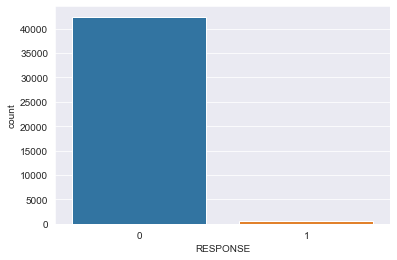

In [57]:
sns.countplot(train['RESPONSE']);

In [60]:
train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

Our train data is highly unbalanced. Only around 1% of observations are positive. That's why ROC AUC score is used as a metric in the competition. 

We already know that in some of the columns missing values are encoded with -1,0 or 9. We need to decode those values to see how much data is actually missing in the dataset.

In [58]:
train = classification_decode_nan(train,values_nan)

Now, let's how much data is missing in every column.

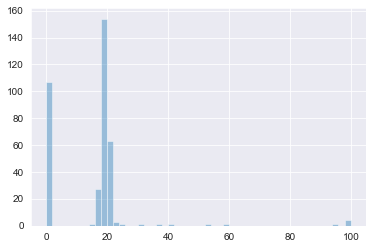

In [59]:
train_null = train.isnull().sum()/len(train)*100
sns.distplot(train_null, bins=50, kde=False);

Only handful of columns have more than 50% of the data missing. They will be dropped. The rest will be dealt as in the first part of the project. Mean values for numeric data (at least the columns we know of as numeric) and modal values for categorical data.

In [60]:
# columns to keep
keep_columns = train_null[train_null<50].index.to_list()
train = train[keep_columns]

In [61]:
len(keep_columns)

359

In [62]:
# remove 'RESPONSE' column from the final list of columns
keep_columns.remove('RESPONSE')

# save the columns into a pickle for later use
with open('classification_cols.pkl','wb') as f:
    pickle.dump(keep_columns,f)

In [63]:
train.select_dtypes(['object']).head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W


We have several columns that We didn't use in the first part of the project. For example, column 'EINGEFUEGT_AM' which, as I understand, shows when the data observation first appeared in the database. I'd like to keep only the year of that date. 'CAMEO_DEU_2015' won't be dropped in this part of the project. Instead, two different columns will be engineered out of it: one column will contain the number of 'CAMEO_DEU_2015' column and another column will contain a letter (e.g. 5D value will be in two different columns as 5 and D). Columns 'YOUTH_DECADE' and 'MOVEMENT' will again be created out of 'PRAEGENDE_JUGENDJAHRE' column.

In [64]:
# new columns for the dataframe
train = new_columns(train)
train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,YOUTH_DECADE,MOVEMENT
0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,3.0,3,0,2,4,1992.0,5.0,D,40.0,Mainstream
1,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,7.0,1,0,2,3,1997.0,5.0,B,70.0,Mainstream
2,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,3,0,1,4,1995.0,2.0,D,40.0,Avantgarde
3,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,1.0,3,0,2,4,1992.0,2.0,D,40.0,Avantgarde
4,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,3.0,3,0,1,3,1992.0,7.0,B,50.0,Mainstream


In [65]:
# fill in NaNs
train = classification_fill_nan(train,values)
train.isnull().sum().any()

False

In [66]:
# label object type data
train = label_obj(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 361 entries, AGER_TYP to MOVEMENT
dtypes: float64(270), int32(4), int64(87)
memory usage: 117.7 MB


We have our dataset ready for feature selection with RandomForest classifier. First, I want to try feature selection and model training on undersampled data (to even negative and positive responses), then on a full dataset and see which one gets a better score on cross validation.

In [67]:
undersampled = undersample(train,shuffle)
undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 15074 to 9910
Columns: 361 entries, AGER_TYP to MOVEMENT
dtypes: float64(270), int32(4), int64(87)
memory usage: 2.9 MB


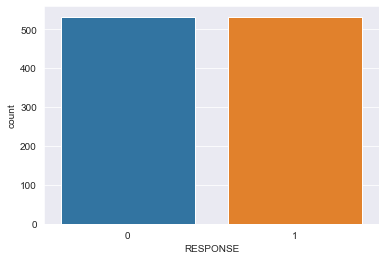

In [68]:
sns.countplot(undersampled['RESPONSE']);

In [69]:
# initialize Random Forest
rfc = RandomForestClassifier(random_state=42)

# data to train on
X = undersampled.drop('RESPONSE', axis=1)
y = undersampled['RESPONSE']

# train the model
rfc.fit(X,y)

# feature importance
rfc_undersampled_feature = pd.Series(data=rfc.feature_importances_,
                              index=X.columns)
rfc_undersampled_feature.sort_values(ascending=False, inplace=True)
rfc_undersampled_feature.head(10)

D19_SOZIALES            0.066813
D19_KONSUMTYP_MAX       0.028082
D19_KONSUMTYP           0.020516
RT_SCHNAEPPCHEN         0.011714
ALTERSKATEGORIE_GROB    0.009108
VK_DISTANZ              0.008319
KBA13_ANZAHL_PKW        0.008170
ANREDE_KZ               0.007599
GFK_URLAUBERTYP         0.007494
VK_ZG11                 0.007035
dtype: float64

In [70]:
values[values['Attribute'].str.contains('D19_', case=False, na=False)].dropna().head()

,Attribute,Description,Value,Meaning
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
162,D19_BANKEN_DIREKT_RZ,transactional activity based on the product gr...,0,no transaction known
163,D19_BANKEN_DIREKT_RZ,- on grid level -,1,Multibuyer 0-12 months


Interestingly, although we do not have explanation for 3 most important features for Random forest classifier, the 'D19_' group of features seem to represent person's activity with a certain product (bank,insurance,etc.). And there are some features that were important during the first part of the project. Features that represent person's age or sex, for example.

Now, the idea is to use features that contributed more than certain threshold to random forest decision making. I'll use 0.002 at the begining but when the final classifier is picked I'll try tunning that number.

In [71]:
# data to train on
X = pd.read_csv('mailout_train.csv')
X = undersample(X,shuffle)
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

In [72]:
# bucnh of classifiers to train
models = {
    'Logistic Regression':LogisticRegression(random_state=42),
    'K-Nearest Neighbors':KNeighborsClassifier(),
    'Decision Tree':DecisionTreeClassifier(random_state=42),
    'Random Forest':RandomForestClassifier(random_state=42),
    'Support Vector Machine':SVC(random_state=42),
    'LightGBM':LGBMClassifier(random_state=42),
    'XGBoost':XGBClassifier(random_state=42)
}

In [73]:
# check out the following combination:
# undersampled data, feature importance with Random forest on undersampled data,
# threshold 0.002

In [25]:
# data to train on
X = pd.read_csv('mailout_train.csv')
X = undersample(X,shuffle)
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

scores1 = train_model(X,y,models,values_nan,values,rfc_undersampled_feature)

Training...: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:52<00:00,  7.51s/it]


In [26]:
scores1

,Classifier,ROC AUC Score
6,XGBoost,0.799179
5,LightGBM,0.781062
3,Random Forest,0.773428
0,Logistic Regression,0.679507
2,Decision Tree,0.646768
1,K-Nearest Neighbors,0.517296
4,Support Vector Machine,0.512509


XGBoost performed the best so far with LightGBM and Random Forest following it. Let's check the same features and classifiers trained on the full dataset. (NOTE! The results are mean of 10-fold split).

In [30]:
# data to train on
X = pd.read_csv('mailout_train.csv')
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

scores2 = train_model(X,y,models,values_nan,values,rfc_undersampled_feature)

Training...: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [12:58<00:00, 111.17s/it]


In [31]:
scores2

,Classifier,ROC AUC Score
5,LightGBM,0.712436
6,XGBoost,0.711619
0,Logistic Regression,0.682110
3,Random Forest,0.612646
4,Support Vector Machine,0.530818
1,K-Nearest Neighbors,0.509686
2,Decision Tree,0.508802


Classifiers trained on the full dataset performed considerably worse than when trained on balanced dataset. Plus, it took much more time training them.

Now, let's try a set of features filtered out after training Random forest on full dataset.

In [74]:
# feature importances with Random Forest on the full dataset
X = pd.read_csv('mailout_train.csv')

# as in part 1 of the project I'll drop some of the columns right away
X = X.drop(['Unnamed: 0','LNR'], axis=1)

X = classification_decode_nan(X,values_nan)
X_null = X.isnull().sum()/len(X)*100
keep_columns2 = X_null[X_null<50].index.to_list()
X = X[keep_columns2]

X = new_columns(X)

X = classification_fill_nan(X,values)

X = label_obj(X)

# initialize Random Forest
rfc = RandomForestClassifier(random_state=42)

# data to train on
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)


# train the model
rfc.fit(X,y)

# feature importance
rfc_fulldata_feature = pd.Series(data=rfc.feature_importances_,
                              index=X.columns)
rfc_fulldata_feature.sort_values(ascending=False, inplace=True)
rfc_fulldata_feature.head(10)

KBA13_ANZAHL_PKW        0.010070
GFK_URLAUBERTYP         0.009935
LP_LEBENSPHASE_FEIN     0.007672
EXTSEL992               0.006946
ONLINE_AFFINITAET       0.006834
CJT_GESAMTTYP           0.006543
ALTER_HH                0.005572
EINGEZOGENAM_HH_JAHR    0.005524
RT_UEBERGROESSE         0.005335
VERDICHTUNGSRAUM        0.005307
dtype: float64

In [391]:
# check the following:
# undersampled dataset, feature importance with Random Forest on full dataset
# threshold 0.002

In [19]:
# data to train on
X = pd.read_csv('mailout_train.csv')
X = undersample(X,shuffle)
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

scores3 = train_model(X,y,models,values_nan,values,rfc_fulldata_feature)

Training...: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [01:13<00:00, 10.48s/it]


In [20]:
scores3

,Classifier,ROC AUC Score
6,XGBoost,0.777411
5,LightGBM,0.769584
3,Random Forest,0.726712
2,Decision Tree,0.675489
0,Logistic Regression,0.673428
1,K-Nearest Neighbors,0.519672
4,Support Vector Machine,0.511443


In [393]:
# check the following:
# full dataset, feature importance with Random Forest on full dataset
# threshold 0.002

In [396]:
# data to train on
X = pd.read_csv('mailout_train.csv')
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

scores4 = train_model(X,y,models,values_nan,values,fulldata_feature)

Training...: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [14:15<00:00, 122.28s/it]


In [397]:
scores4

,Classifier,ROC AUC Score
5,LightGBM,0.715726
6,XGBoost,0.692240
0,Logistic Regression,0.658358
3,Random Forest,0.597534
2,Decision Tree,0.516839
4,Support Vector Machine,0.513759
1,K-Nearest Neighbors,0.508857


So, the first combination (feature importances trained with Random forest on undersampled data, XGBoost trained on undersampled data as well) showed the result of 0.799179 (mean of 10-fold split cross validation). Now I want to do Bayesian optimization with hyperoprt python library and try tuning the pipeline's parameters.

In [413]:
# data to train on 
X = pd.read_csv('mailout_train.csv')
X = undersample(X,shuffle)
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

# search space / different parameters to tune in the pipeline
space = {
    'max_depth' : hp.choice('max_depth', range(3, 51, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 1, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 705, 5)),
    'gamma' : hp.quniform('gamma', 0, 1.0, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 25, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'threshold':hp.choice('threshold',[0.001,0.002,0.003,0.004])
}

# a loss function
def obj_func(space):
    """
    Creates a classifier with selected parameters, trains and evaluates it using ROC_AUC_score as metric
    Uses Bayesian optimization to minimize custom written loss function.
    Returns best (lowest) loss and best parameters for the classifier

    space - a dictionary with parameters for search space  
    """

    # pipeline to tune
    pipeline = Pipeline(steps=[
                            ('features',ProcessForClassification(values_nan,values,
                                                                 rfc_undersampled_feature,
                                                                 threshold=space['threshold'])),
                            ('clf',XGBClassifier(max_depth=space['max_depth'],
                                                learning_rate=space['learning_rate'],
                                                n_estimators=space['n_estimators'],
                                                gamma=space['gamma'],
                                                min_child_weight=space['min_child_weight'],
                                                subsample=space['subsample'],
                                                colsample_bytree=space['colsample_bytree'],
                                                random_state=42))
    ])

    # splits for cross validation
    split = StratifiedShuffleSplit(n_splits=10)

    # corss validation mean score
    score = cross_val_score(pipeline,X,y, cv=split, scoring='roc_auc', error_score='raise').mean()

    # loss
    # to minimize loss need to maximize cross validation score
    loss = 1 - score

    return {'loss':loss,'status':STATUS_OK}


# trials
trials = Trials()

# 500 evaulations
best = fmin(fn=obj_func, space=space, algo=tpe.suggest, max_evals=500, 
            trials=trials, verbose=1)

100%|███████████████████████████████████████████| 500/500 [3:03:27<00:00, 22.01s/trial, best loss: 0.16808176100628935]


In [21]:
# check out what parameters gave the lowest loss
best

{'colsample_bytree': 0.66,
 'gamma': 0.79,
 'learning_rate': 0.06,
 'max_depth': 16,
 'min_child_weight': 19.0,
 'n_estimators': 3,
 'subsample': 0.62,
 'threshold': 2}

Now I'll use the parameters above, train the classifier on undersampled data, make predicitons on the test set and submit them to kaggle leaderboard.

In [39]:
# parameters
parameters = {'colsample_bytree': 0.66,
 'gamma': 0.79,
 'learning_rate': 0.06,
 'max_depth': 19,
 'min_child_weight': 19.0,
 'n_estimators': 23,
 'subsample': 0.62}
# and threshold of 0.003

# data to train on
X = pd.read_csv('mailout_train.csv')
X = undersample(X,shuffle)
y = X['RESPONSE']
X = X.drop('RESPONSE', axis=1)

# test data
test = pd.read_csv('mailout_test.csv')

sub = file_for_submission(XGBClassifier(**parameters,random_state=42),X,y,test,'xgb_tuned.csv',
                         values,values_nan,rfc_undersampled_feature,threshold=0.003)

,LNR,RESPONSE
0,1754,0.654699
1,1770,0.697541
2,1465,0.269939
3,1470,0.257530
4,1478,0.294690


The submission got 0.80251 on public leader board (30% of test data). It will be very interesting to see how that result holds on private leaderboard (70% of test data). Considering that classifier's parameters were tuned using 10-fold split cross validation, the model should stand not far from the public leaderboard's result.